# Table of Contents  <a class="anchor" id="toc"></a>

<div style="background: #f9f9f9 none repeat scroll 0 0;border: 1px solid #aaa;display: table;font-size: 95%;margin-bottom: 1em;padding: 20px;width: 400px;">
<h3>Contents</h3>
</ul>
<li style="list-style: outside none none !important;"><a 
    
>1 Data processing</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;"><li style="list-style: outside none none !important;"><a
                                                                             href="#step1.1">1.1 Handling Misspelled data</a></li>
            <li style="list-style: outside none none !important;"><a
href="#step1.2">1.2 Handling Contractions</a></li>
            <li style="list-style: outside none none !important;"><a 
href="#step1.3">1.3 Replacing Abbreviations</a></li>
            <li style="list-style: outside none none !important;"><a                                                                                   href="#step1.4">1.4 Visualizing length of tweets</a></li>
            <li style="list-style: outside none none !important;"><a 
                                                                     href="#step1.5">1.5 Visualizing word count in each tweet</a></li>
            <li style="list-style: outside none none !important;"><a 
href="#step1.6">1.6 Collecting all words</a></li>
 </ul>
<li style="list-style: outside none none !important;"><a href="#step2.1">2 Visualizing and data attributes</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
            <li style="list-style: outside none none !important;"><a href="#step2.1">2.1 Viewing most common stop words used in tweets</a></li>
            <li style="list-style: outside none none !important;"><a href="#step2.2">2.2 Viewing Punctuations in tweets</a></li>
            <li style="list-style: outside none none !important;"><a href="#step2.3">2.3 Viewing Common words in tweets</a></li>  
            <li style="list-style: outside none none !important;"><a 
href="#step2.4">2.4 N-gram analysis</a></li>
    
 </ul>
<li style="list-style: outside none none !important;"><a href="#step3.1">3 Data cleaning</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">    
            <li style="list-style: outside none none !important;"><a href="#step3.1">3.1 Cleaning URLs and HTML tags</a></li>
            <li style="list-style: outside none none !important;"><a         href="#step3.2">3.2 Cleaning Punctuations and emojis</a></li>
            <li style="list-style: outside none none !important;"><a 
                                                                     href="#step3.3">3.3  Cleaning stop words </a></li>
            <li style="list-style: outside none none !important;"><a href="#step3.4">3.4 Using Glo-Ve for word embeddings</a></li>
            <li style="list-style: outside none none !important;"><a 
href="#step3.5">3.5 Train-Test split </a></li>
            <li style="list-style: outside none none !important;"><a></li> 
</ul>
<li style="list-style: outside none none !important;"><a href="step4.1">4 Creating Models</a></li>
      <ul style="font-weight: 700;text-align: left;list-style: outside none none !important;">
            <li style="list-style: outside none none !important;"><a href="#step4.1">4.1 LSTM Model with Glove Embeddings</a></li>
            <li style="list-style: outside none none !important;"><a href="#step4.2">4.2 Plotting accuracy and loss curves</a></li>
            <li style="list-style: outside none none !important;"><a  href="#step4.3">4.3 LSTM with Glove Results</a></li>
            <li style="list-style: outside none none !important;"><a 

</ul>
</div>

In [113]:
import numpy as np 
import pandas as pd 
import emoji
import keras
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

from collections import defaultdict
from collections import Counter

from sklearn import decomposition, model_selection,preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer





In [114]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test= pd.read_csv("../input/nlp-getting-started/test.csv")
print(train.head(),train.shape)

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   (7613, 5)


count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

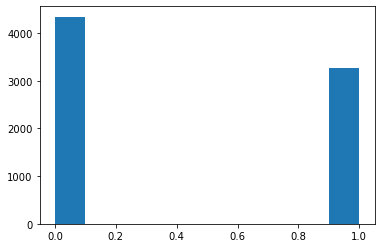

In [115]:
plt.hist(train['target'])
train['target'].describe()

<a id='step1.1'></a>
1.1. Misspelled data

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [116]:
DATA_PATH = '../input/spelling/aspell.txt'
misspell_data = pd.read_csv(DATA_PATH,
                            sep=':',
                            names=['correction', 'misspell'])

misspell_data.misspell = misspell_data.misspell.str.strip()
misspell_data.misspell = misspell_data.misspell.str.split(" ")
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)
misspell_data.drop_duplicates("misspell", inplace=True)
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))

In [117]:
def misspell_correction(inp):
    for x in inp.split(): 
        if x in miss_corr.keys(): 
            inp = inp.replace(x, miss_corr[x])
    return inp

train["content"] = train["text"].apply(lambda x : misspell_correction(x))
test["content"] = test["text"].apply(lambda x : misspell_correction(x))

print(train["content"].head())


0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: content, dtype: object


<a id='step1.2'></a>

1.2. Contractions in words

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [118]:
contractions = pd.read_csv("../input/contractions/contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))

def cont_to_meaning(val): 
  
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

train["content"] = train["content"].apply(lambda x : cont_to_meaning(x))
test["content"] = test["content"].apply(lambda x : cont_to_meaning(x))
print(train["content"])

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: content, Length: 7613, dtype: object


<a id='step1.3'></a>
1.3. Replacing Abbreviations 

In [119]:
abbreviations = pd.read_csv("../input/abbreviations-and-slangs-for-text-preprocessing/Abbreviations and Slang.csv")
abrevtn_dic = dict(zip(abbreviations.Abbreviations, abbreviations.Text))

def abbrev2_word(word):
    word= word.lower()
    if word in abrevtn_dic.keys():
        return abrevtn_dic[word]
    else: 
        return word

def abbrev2_text(text):
    sentnc = word_tokenize(text)
    sentnc = [abbrev2_word(word) for word in sentnc]
    text = ' '.join(sentnc)
    return text

train["content"] = train["content"].apply(lambda x: abbrev2_text(x))
test["content"] = test["content"].apply(lambda x: abbrev2_text(x))

<a id='step1.4'></a>

1.4. Visualizing length of tweets  

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [120]:

train["length"] = train["text"].str.len()
print(train.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                            content  length  
0       1  our deeds are the reason of this # earthquake ...      69  
1       1            forest fire near la ronge sask . canada      38  
2       1  all residents asked to 'shelter in place ' are...     133  
3       1  13,000 people receive # wildfires evacuation o...      65  
4       1  just got sent this photo from ruby # alaska as...      88  


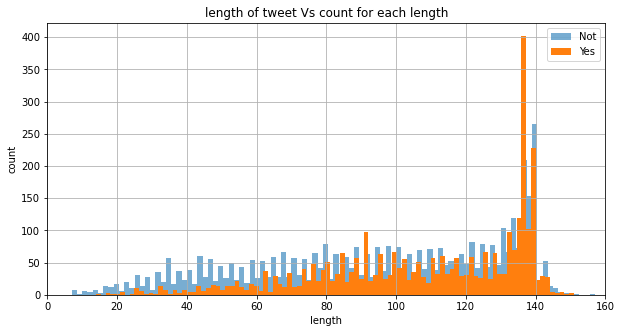

In [121]:

fig, ax = plt.subplots(figsize=(10,5))
plt.hist(train[train['target']==0]['length'],alpha = 0.6, bins=100, label='Not')
plt.hist(train[train['target']==1]['length'],alpha = 1, bins=100, label='Yes')
ax.set(title= 'length of tweet Vs count for each length',xlabel= 'length',
       ylabel='count',xlim=(0,160))
ax.legend(loc='upper right')
plt.grid()
plt.show()


<a id='step1.5'></a>

1.5. Visualizing average length of word in each tweet

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                            content  length  \
0       1  our deeds are the reason of this # earthquake ...      69   
1       1            forest fire near la ronge sask . canada      38   
2       1  all residents asked to 'shelter in place ' are...     133   
3       1  13,000 people receive # wildfires evacuation o...      65   
4       1  just got sent this photo from ruby # alaska as...      88   

   word1Len  word0Len  
0      14.0       NaN  
1       8.0       NaN  
2      24.0       NaN  
3       

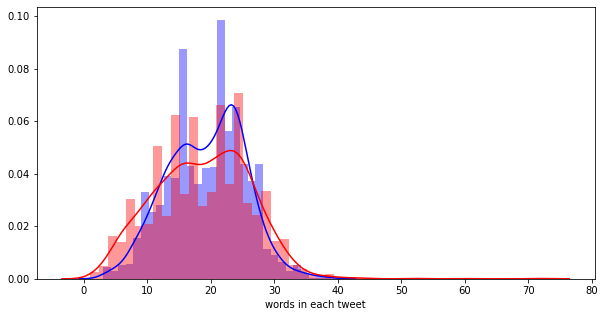

In [122]:
fig,ax=plt.subplots(figsize=(10,5))

train['word1Len']=train[train['target']==1]['content'].str.count(' ') + 1
train['word0Len']=train[train['target']==0]['content'].str.count(' ') + 1
sns.distplot(train['word1Len'].map(lambda i: np.mean(i)),color='blue')
sns.distplot(train['word0Len'].map(lambda i: np.mean(i)),color='red')
ax.set(xlabel='words in each tweet')
print(train.head())

<a id='step1.6'></a>
1.6. Collecting all words

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [123]:
wordsIn0= []
wordsIn1= []
# collecting all words in each target
for row in train[train['target']==0]['content'].str.split():
        for word in row:
            wordsIn0.append(word)
for row in train[train['target']==1]['content'].str.split():
        for word in row:
            wordsIn1.append(word)
            
words= wordsIn0+wordsIn1

<a id='step2.1'></a>
2.1. Viewing most common stop words used in tweets

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>



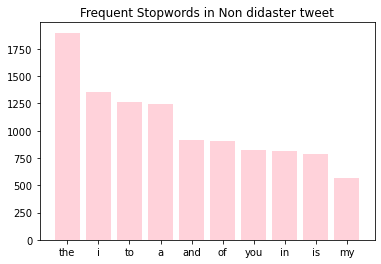

Text(0.5, 1.0, 'Frequent Stopwords in disaster tweet')

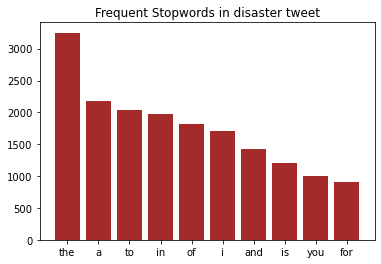

In [124]:
stop = stopwords.words('english')
dic=defaultdict(int)

#collecting stop words used in sentences            
for word in wordsIn0:
    if word in stop:
        dic[word]+=1
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

for word in wordsIn1:
    if word in stop:
        dic[word]+=1
top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

# plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top0)
plt.bar(x,y,color='pink',alpha=0.7)
plt.title('Frequent Stopwords in Non didaster tweet')
plt.show()

p,q=zip(*top1)
plt.bar(p,q,color='brown')
plt.title('Frequent Stopwords in disaster tweet')

2.2. Punctuations in tweets
<a id='step2.2'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

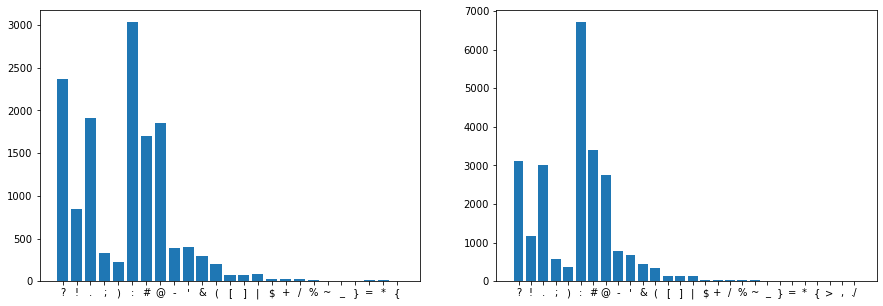

In [125]:
dic=defaultdict(int)
punc = string.punctuation
for i in wordsIn0:
    if i in punc:
        dic[i]+=1
x,y=zip(*dic.items())

for i in wordsIn1:
    if i in punc:
        dic[i]+=1  
p,q=zip(*dic.items())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(x,y)
plt.subplot(122)
plt.bar(p,q)
plt.show()

2.3. Common words in tweets
<a id='step2.3'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

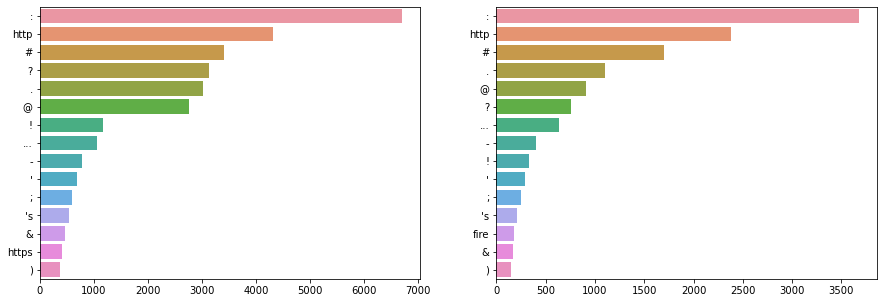

In [126]:
counter0=Counter(words)
counter1=Counter(wordsIn1)

common0=counter0.most_common()
common1=counter1.most_common()

x0,x1=[],[]
y0,y1=[],[]
for word,count in common0[:40]:
    if (word not in stop) :
        x0.append(word)
        y0.append(count)
for word,count in common1[:40]:
    if (word not in stop) :
        x1.append(word)
        y1.append(count)        
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(x=y0,y=x0)
plt.subplot(122)
sns.barplot(x=y1,y=x1)
plt.show()

2.4. N-gram analysis 
> checking for bi-grams
<a id='step2.4'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

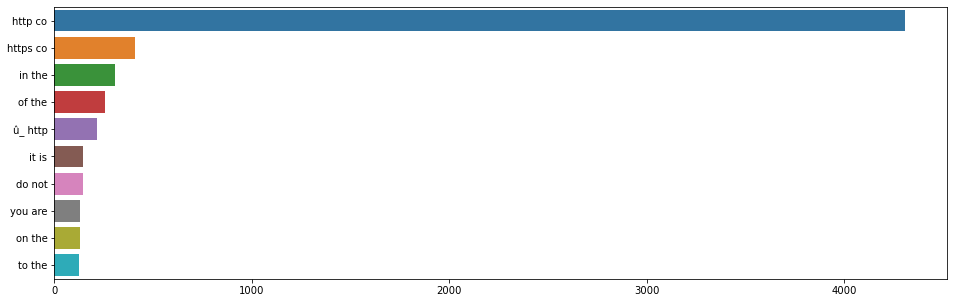

In [127]:
def textBiGrams(line, n=None):
    c_vector = CountVectorizer(ngram_range=(2, 2)).fit(line)
    words_set = c_vector.transform(line)
    freq = words_set.sum(axis=0) 
    words_freq = [(x,freq[0, ind]) for x, ind in c_vector.vocabulary_.items()]
    freq_used =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return freq_used[:n]

plt.figure(figsize=(16,5))
top_bi_grams= textBiGrams(train['content'])[:10]
x,y=map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x)

### **3. DATA CLEANING**

3.1. Cleaning URLs and HTML tags
<a id='step3.1'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [128]:
def url_html_remove(line):
    url = re.compile(r'https?://\S+|www\.\S+<.*?>')
    x= url.sub(r'',line)
    html=  re.compile('<.*?>')
    y=html.sub(r'',x)
    return y
    
train["clean_content"]=train.content.apply(lambda x: url_html_remove(x))
test["clean_content"]=test.content.apply(lambda x: url_html_remove(x))


3.2. Cleaning Punctuations and Emojis
<a id='step3.2'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [129]:
def punct_rem(val):   
    for x in string.punctuation: 
        if x in val: 
            val = val.replace(x, " ") 
    return val
train['clean_content']= train['clean_content'].apply(lambda x:' '.join(punct_rem(emoji.demojize(x)).split()))
test['clean_content']= test['clean_content'].apply(lambda x:' '.join(punct_rem(emoji.demojize(x)).split()))

print(train.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                            content  length  \
0       1  our deeds are the reason of this # earthquake ...      69   
1       1            forest fire near la ronge sask . canada      38   
2       1  all residents asked to 'shelter in place ' are...     133   
3       1  13,000 people receive # wildfires evacuation o...      65   
4       1  just got sent this photo from ruby # alaska as...      88   

   word1Len  word0Len                                      clean_content  
0      14.0       NaN  our de

3.3. Cleaning stop words
<a id='step3.3'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [130]:
train['cleaned_words']= train['clean_content'].apply(lambda x:[i for i in x.split() if i not in  stop])

test['cleaned_words']= test['clean_content'].apply(lambda x:[i for i in x.split() if i not in  stop])
print(train['cleaned_words'])

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [13, 000, people, receive, wildfires, evacuati...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [aria, ahrary, thetawniest, control, wild, fir...
7610    [m1, 94, 01, 04, utc, 5km, volcano, hawaii, ht...
7611    [police, investigating, e, bike, collided, car...
7612    [latest, homes, razed, northern, california, w...
Name: cleaned_words, Length: 7613, dtype: object


3.4. Bag of words
<a id='step3.4'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [131]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer



3.4. Using Glo-Ve for word embeddings
<a id='step3.4'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [132]:
word_embeddings={}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt','r') as f:
    for line in f:
        data=line.split()
        x = data[0]
        vectors=np.asarray(data[1:],'float32')
        word_embeddings[x]=vectors
f.close()

In [133]:
from tqdm import tqdm

corpus= []
for x in tqdm(train["clean_content"]):
    words=[word.lower() for word in word_tokenize(x)]
    corpus.append(words)
for x in tqdm(test["clean_content"]):
    words=[word.lower() for word in word_tokenize(x)]
    corpus.append(words)

100%|██████████| 3263/3263 [00:00<00:00, 3624.95it/s]


In [134]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

l=50
token=Tokenizer()
token.fit_on_texts(corpus)
seq=token.texts_to_sequences(corpus)

text=pad_sequences(seq,maxlen=l,truncating='post',
                        padding='post')
index=token.word_index
print(len(index))

28233


In [135]:
len_matrix=len(index)+1
word_matrix=np.zeros((len_matrix,100))

for word,i in tqdm(index.items()):
    if i < len_matrix:
        vec=word_embeddings.get(word)
        if vec is not None:
            word_matrix[i]=vec

100%|██████████| 28233/28233 [00:00<00:00, 293082.13it/s]


3.5. Train-Test split
<a id='step3.5'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [136]:
length= train.shape[0]
print("length:",length)
train_data = text[:length]
test_data=text[length:]

labels = train["target"].values

x_train, x_val, y_train, y_val = train_test_split(train_data,labels, test_size=0.2, 
                                                random_state=10)

print('train data shape', x_train.shape)


length: 7613
train data shape (6090, 50)


### 4.1. LSTM Model with GloVe embeddings
<a id='step4.1'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

In [137]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model=Sequential()

embedding=Embedding(len_matrix,100,embeddings_initializer=Constant(word_matrix),
                   input_length=l,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))


model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=5e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           2823400   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 50)               

In [138]:
lstm_history=model.fit(x_train,y_train,batch_size=16,epochs=15,
                  validation_data=(x_val,y_val),verbose=2)

Epoch 1/15
381/381 - 27s - loss: 0.6369 - accuracy: 0.6409 - val_loss: 0.5264 - val_accuracy: 0.7518
Epoch 2/15
381/381 - 26s - loss: 0.5177 - accuracy: 0.7596 - val_loss: 0.4906 - val_accuracy: 0.7781
Epoch 3/15
381/381 - 26s - loss: 0.4967 - accuracy: 0.7703 - val_loss: 0.4695 - val_accuracy: 0.7965
Epoch 4/15
381/381 - 26s - loss: 0.4888 - accuracy: 0.7767 - val_loss: 0.4611 - val_accuracy: 0.7978
Epoch 5/15
381/381 - 25s - loss: 0.4804 - accuracy: 0.7813 - val_loss: 0.4588 - val_accuracy: 0.7971
Epoch 6/15
381/381 - 26s - loss: 0.4763 - accuracy: 0.7831 - val_loss: 0.4538 - val_accuracy: 0.8024
Epoch 7/15
381/381 - 26s - loss: 0.4729 - accuracy: 0.7819 - val_loss: 0.4596 - val_accuracy: 0.8030
Epoch 8/15
381/381 - 26s - loss: 0.4653 - accuracy: 0.7842 - val_loss: 0.4471 - val_accuracy: 0.8096
Epoch 9/15
381/381 - 25s - loss: 0.4626 - accuracy: 0.7913 - val_loss: 0.4413 - val_accuracy: 0.8063
Epoch 10/15
381/381 - 27s - loss: 0.4655 - accuracy: 0.7862 - val_loss: 0.4661 - val_accura

> Epoch 10/10 batch_size=4, no extra layer
1523/1523 - 274s - loss: 0.4250 - accuracy: 0.8148 - val_loss: 0.4205 - val_accuracy: 0.8227
> Epoch 10/10 batch_size=4, 1 extra layer
1523/1523 - 277s - loss: 0.4239 - accuracy: 0.8151 - val_loss: 0.4202 - val_accuracy: 0.8102
> Epoch 10/10 batch_size=8, 1 extra layer
762/762 - 142s - loss: 0.3759 - accuracy: 0.8378 - val_loss: 0.4352 - val_accuracy: 0.8148

4.2. Plotting accuracy and loss curves
<a id='step4.2'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>

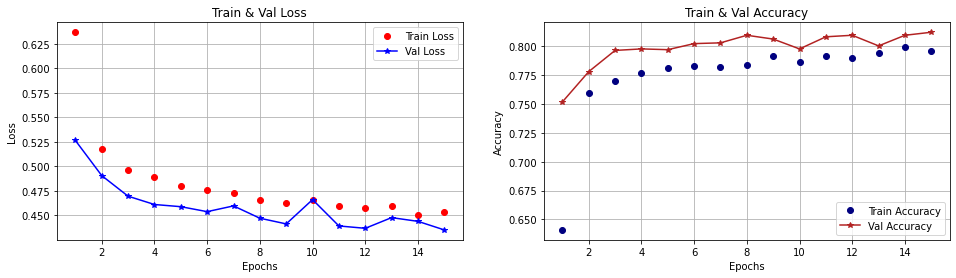

In [139]:
def show_plots(neural_ntwk):
    loss_vals = neural_ntwk['loss']
    val_loss_vals = neural_ntwk['val_loss']
    epochs = range(1, len(neural_ntwk['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    ax[0].plot(epochs, loss_vals, color='R',marker='o',
               linestyle=' ', label='Train Loss')
    ax[0].plot(epochs, val_loss_vals, color='B',
               marker='*', label='Val Loss')
    ax[0].set(title='Train & Val Loss', xlabel='Epochs',ylabel='Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = neural_ntwk['accuracy']
    val_acc_vals = neural_ntwk['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o',
               ls=' ', label='Train Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick',
               marker='*', label='Val Accuracy')
    ax[1].set(title='Train & Val Accuracy',xlabel='Epochs',ylabel='Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
# show_plots(neural_ntwk1.history)
show_plots(lstm_history.history)

4.3 LSTM with Glove Results
<a id='step4.3'></a>

<a class="anchor" id="dp-re"></a>
<a href="#toc"><img src= "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Circle-icons-arrow-up.svg/1200px-Circle-icons-arrow-up.svg.png" style="width:20px;hight:20px;float:left" >Back to the table of contents</a>


In [145]:
tGloVe = model.predict(test_data)
test_pred_GloVe_int = tGloVe.round().astype('int')


In [147]:

# output = pd.DataFrame({'id':test_data['id'],
#                       'target': test_pred_GloVe_int})
# output.to_csv('realfake_pred.csv', index=False)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices